In [1]:
import galsim
import batsim
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib.pyplot as plt
import fpfs
from time import time

from tqdm import tqdm, trange

from importlib import reload
reload(batsim)

<module 'batsim' from '/home/b7009348/.local/lib/python3.11/site-packages/batsim/__init__.py'>

In [2]:
# load in COSMOS catalog
cosmos_cat = galsim.COSMOSCatalog()

# create a galaxy
rng = galsim.BaseDeviate(9)
randind = cosmos_cat.selectRandomIndex(rng=rng)
rec = cosmos_cat.getParametricRecord(index=randind)

gal = cosmos_cat.makeGalaxy(index=randind, gal_type='parametric')

# get simulation pixel scale and number
sim_scale = gal.nyquist_scale
sim_nn = gal.getGoodImageSize(sim_scale)
print("Sim scale: ", sim_scale)
print("Sim nn: ", sim_nn)

Sim scale:  0.03906703551612214
Sim nn:  54


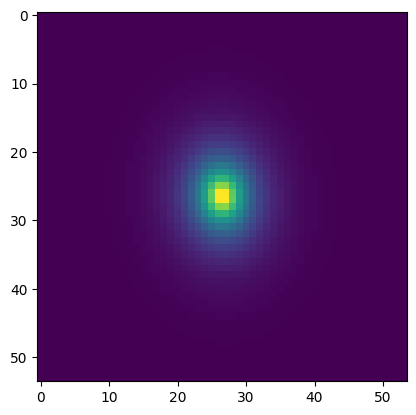

In [3]:
plt.imshow(gal.drawImage(nx=sim_nn, ny=sim_nn, scale=sim_scale).array)

In [4]:
# rotate and cancel shape noise
nrot = 4
rotated_gals = []
for i in range(nrot):
    rot_ang = np.pi / nrot * i
    ang = rot_ang * galsim.radians
    gal = gal.rotate(ang)
    rotated_gals.append(gal)

In [5]:
# This is my attempt to create an LSST-like PSF
# LSST Specifications
diameter = 8.4  # meters
effective_diameter = 6.423  # meters, area weighted
seeing = 0.67  # arcseconds

# Attempt measurement and detection with FPFS
scale = 0.2
nn = 128
rcut = nn // 4
print("rcut: ", rcut)

TotPSF = galsim.Moffat(beta=3.5, fwhm=seeing, flux=1.0, trunc=4*seeing)
psf_arr = TotPSF.shift(0.5*scale, 0.5*scale).drawImage(
    nx=rcut*2, ny=rcut*2, scale=scale, method='auto').array

# reduced shear and lensing magnification
gamma1 = 0.02
gamma2 = 0.0
kappa = 0.0

g1 = gamma1 / (1 - kappa)
g2 = gamma2 / (1 - kappa)
mu = 1 / ((1 - kappa) ** 2 - gamma1**2 - gamma2**2)

# BATSim lensing transform object
lens = batsim.LensTransform(gamma1=gamma1, gamma2=gamma2, kappa=kappa)

galsim_arrs = []
batsim_arrs = []
for obj in tqdm(rotated_gals):
    # shear using galsim
    lensed_gal = obj.shear(g1=g1)
    smeared_gal = galsim.Convolve([lensed_gal, TotPSF])
    gs_img = (
        smeared_gal.shift(0.5*scale, 0.5*scale).drawImage(
            nx=nn, ny=nn, scale=scale, method='auto')
    )
    galsim_arrs.append(gs_img.array)

    # shear using batsim
    bat_img = batsim.simulate_galaxy(
        ngrid=nn,
        pix_scale=scale,
        gal_obj=obj,
        transform_obj=lens,
        psf_obj=TotPSF
    )
    
    batsim_arrs.append(bat_img)

rcut:  32


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 15.67it/s]


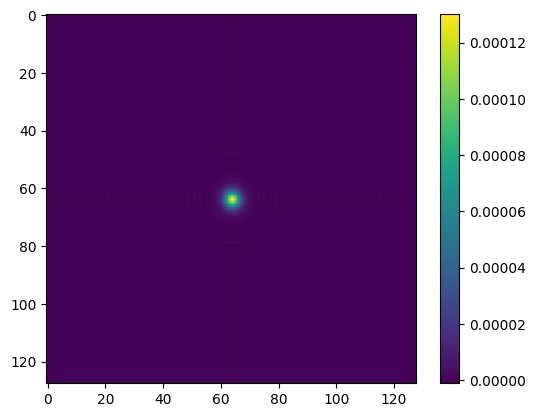

In [6]:
plt.imshow((batsim_arrs[0]-galsim_arrs[0]))
plt.colorbar()
#np.testing.assert_array_almost_equal(batsim_arrs[0], galsim_arrs[0])

In [7]:
def test_kernel_size(sigma_arcsec, psf_arr, gal_arr_list, scale, rcut):

    # initialize FPFS shear measurement task
    fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=sigma_arcsec, pix_scale=scale)

    p1 = nn //2 - rcut
    p2 = nn //2 - rcut
    psf_arr_pad = np.pad(psf_arr, ((p1, p1), (p2, p2)))

    all_mms = []
    for gal_arr in gal_arr_list:
        coords = fpTask.detect_sources(gal_arr,psf_arr_pad,thres=0.01,thres2=-0.00,)
        # measure shear with FPFS on individual galaxies
        mms = fpTask.measure(gal_arr, coords)
        mms = fpTask.get_results(mms)
        all_mms.append(mms)
    combined_mms = rfn.stack_arrays(all_mms, usemask=False, asrecarray=True)

    # convert momemnts to ellipticity estimates
    ells = fpfs.catalog.fpfs_m2e(combined_mms, const=2000)
    resp = np.average(ells['fpfs_R1E'])
    shear = np.average(ells['fpfs_e1'])/resp
    shear_err = np.std(ells["fpfs_e1"]) / np.abs(resp) / np.sqrt(len(gal_arr_list))
    m_bias = abs(shear - g1)/g1

    return shear, shear_err, m_bias

In [8]:
# smaller kernel
kernel1 = 0.4

# measure on galsim galaxies
shear, shear_err, m_bias = test_kernel_size(sigma_arcsec=kernel1, psf_arr=psf_arr, gal_arr_list=galsim_arrs, scale=scale, rcut=rcut)
print("Galsim shear: ", shear)
print("Galsim shear error: ", shear_err)
print("Galsim shear bias: %1.4e"%m_bias)

print("------------------------------------------")

# measure on batsim galaxies
shear, shear_err, m_bias = test_kernel_size(sigma_arcsec=kernel1, psf_arr=psf_arr, gal_arr_list=batsim_arrs, scale=scale, rcut=rcut)
print("Batsim shear: ", shear)
print("Batsim shear error: ", shear_err)
print("Batsim shear bias: %1.4e"%m_bias)

Galsim shear:  0.01999949748440181
Galsim shear error:  0.04301109653851252
Galsim shear bias: 2.5126e-05
------------------------------------------
Batsim shear:  0.019999542907335296
Batsim shear error:  0.04301123823396723
Batsim shear bias: 2.2855e-05


In [9]:
# larger kernel
kernel2 = 0.7

# measure on galsim galaxies
shear, shear_err, m_bias = test_kernel_size(sigma_arcsec=kernel2, psf_arr=psf_arr, gal_arr_list=galsim_arrs, scale=scale, rcut=rcut)
print("Galsim shear: ", shear)
print("Galsim shear error: ", shear_err)
print("Galsim shear bias: %1.4e"%m_bias)
    
print("------------------------------------------")

# measure on batsim galaxies
shear, shear_err, m_bias = test_kernel_size(sigma_arcsec=kernel2, psf_arr=psf_arr, gal_arr_list=batsim_arrs, scale=scale, rcut=rcut)
print("Batsim shear: ", shear)
print("Batsim shear error: ", shear_err)
print("Batsim shear bias: %1.4e"%m_bias)

Galsim shear:  0.01999648481396842
Galsim shear error:  0.0427447729823667
Galsim shear bias: 1.7576e-04
------------------------------------------
Batsim shear:  0.019996916412768954
Batsim shear error:  0.04274481712264796
Batsim shear bias: 1.5418e-04


In [12]:
# Test different kernels
kernels = np.linspace(0.3,1.2,20)

galsim_bias = np.empty(len(kernels))
batsim_bias = np.empty(len(kernels))

for i in trange(len(kernels)):
    # measure on galsim galaxies
    _, _, m_bias = test_kernel_size(sigma_arcsec=kernels[i], psf_arr=psf_arr, gal_arr_list=galsim_arrs, scale=scale, rcut=rcut)
    galsim_bias[i] = m_bias

    # measure on batsim galaxies
    _, _, m_bias = test_kernel_size(sigma_arcsec=kernels[i], psf_arr=psf_arr, gal_arr_list=batsim_arrs, scale=scale, rcut=rcut)
    batsim_bias[i] = m_bias

 45%|████▌     | 9/20 [00:20<00:25,  2.30s/it]


KeyboardInterrupt: 

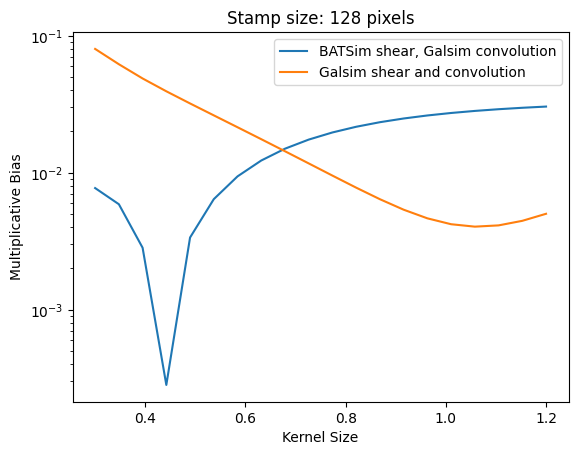

In [ ]:
plt.plot(kernels, abs(batsim_bias), label='BATSim shear, Galsim convolution')
plt.plot(kernels, abs(galsim_bias), label='Galsim shear and convolution')
plt.legend()
plt.xlabel('Kernel Size')
plt.ylabel('Multiplicative Bias')
plt.yscale('log')
plt.title('Stamp size: %d pixels'%nn)
plt.savefig('kernel_size_bias-stamp%d.png'%nn, dpi=300)

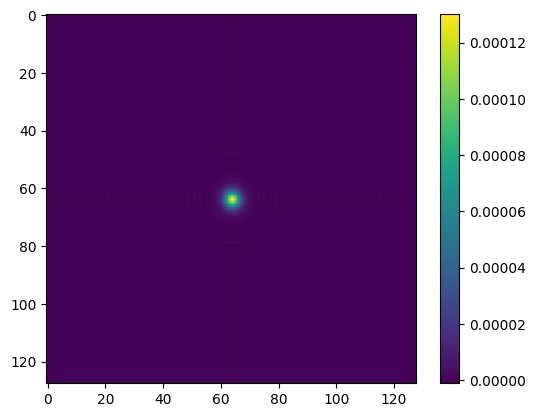

In [10]:
plt.imshow(batsim_arrs[0] - galsim_arrs[0])
plt.colorbar()

In [ ]:
print(galsim_arrs[0].sum(), batsim_arrs[0].sum())

9.558102 9.56023074303059
